# What's an Equitable Bus Lane Budget?
### People riding the bus deserve, at minimum, as much dedicated road space as they would get if they were in cars.


In a perfect world, every bus route would be in a dedicated bus lane. But we aren't living in a transit utopia, how do we build a constituency that can demand better in a persuasive way?

My suggestion - give them a demand that appeals to their sense of fairness<sup>[1]</sup> and give them data to back it up. It is unfair that buses don't get as much space for their passengers as those passengers would get if they were in cars. We can calculate how much space that should be.

<br>

[1] A sense of fairness is powerful - so evolutionarily ingrained that even primates have some sense of it - [watch the monkey videos if you haven't!](https://youtu.be/meiU6TxysCg?t=83)

### Formalizing it a bit

At rush hour, there a a certain number of buses and passengers $p$, on the road. Our road budget is the space $p$ passengers would take if they were in cars 

More formally, the minimum equitable bus-lane budget to work with for 
$i$ buses on the road: 

$car\_length(\sum_{i}(p_{i}))$
 
Where
 
$
\begin{array}
ccar\_length() &=& \text{Length of that many passengers if driving} \\
               &=& n_{cars}*length + \text{gaps b/t cars} - \text{bus length}  \\
               &=& (n_{cars})*16' + ((n_{cars}+1)*70') - 40'
\end{array}
$

and

$
\begin{array}
nn\_cars &=& \text{num_passengers * 1 car per 1.38 passengers} \\
\end{array}
$

### Where'd these number come from?

16' car length is the length of a Toyota Camry

70' gap between cars is around 2 seconds of following distance for cars going 25mph. Safe following distance is often [cited](https://www.statefarm.com/simple-insights/auto-and-vehicles/things-have-changed-since-you-learned-to-drive) as 3-seconds, but I'll use a more conservative estimate because I bet it's more true to reality

40' is the length of Boston buses (40' or 60') - [source](https://cdn.mbta.com/uploadedFiles/Documents/Financials/CIP_8_12_Section_II.pdf) (ctrl-f for '40-foot')

1 car per 1.38 passengers comes from an [MBTA blog post](http://www.mbtabackontrack.com/blog/61-dedicated-bus-lanes)

Number of buses during rush hour - I don't have this info right now. I estimate that the 1-bus runs about 5-10 buses at any given time during rush hour (service every ten minutes for a trip that takes ~40minutes ouside of rush hour) . [Schedule](https://cdn.mbta.com/sites/default/files/route_pdfs/2019-winter/rt001.pdf)

Instead of guesstimating the number of buses running, I'll just use the number of passengers carried by the busiest bus of a given route and route direction

# Okay, let's get to the data

In [1]:
def safe_following_dist(mph, seconds):
    # seconds is following distance in seconds
    # length is length of car
    # mi/h * ft/mi * h/sec = ft/sec
    ft_per_sec = mph * 5280.0 * 1/3600.0     
    return seconds * ft_per_sec

for mph in [25, 35]:
    print(safe_following_dist(mph, 2))

73.33333333333333
102.66666666666667


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

### Data source - MBTA back on track
Specifically - http://www.mbtabackontrack.com/performance/downloads/Bus_Route_Trip_Stop_Composite_Day_FY2017.zip

In [3]:
data = pd.read_csv('Bus_Route_Trip_Stop_Composite_Day_FY2017/Bus_Route_Trip_Stop_Composite_Day_FY2017.csv')

/home/irockafe/miniconda2/envs/bus_proj/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### How are things structured?

In [4]:
data.head()

,GTFS route_id,GTFS direction_id,Trip Start Time,Stop Name,GTFS stop_id,Stop Sequence,Year,Day Type,Boardings,Alightings,Load,Route_Variant,Samples
0,1,1,05:10,MASSACHUSETTS AVE @ HOLYOKE S,110,1,Fall 2017,Weekday,2.1,0.0,2.1,1.0,57
1,1,1,05:10,MASSACHUSETTS AVE @ JOHNSTON,2168,2,Fall 2017,Weekday,0.5,0.0,2.5,1.0,57
2,1,1,05:10,QUINCY ST @ BROADWAY OPP FOGG,2166,3,Fall 2017,Weekday,0.0,0.4,2.1,1.0,57
3,1,1,05:10,QUINCY ST @ HARVARD ST,2167,4,Fall 2017,Weekday,0.0,0.0,2.2,1.0,57
4,1,1,05:10,MT AUBURN ST @ DEWOLFE ST,66,5,Fall 2017,Weekday,0.1,0.0,2.3,1.0,57


In [5]:
data.tail()

,GTFS route_id,GTFS direction_id,Trip Start Time,Stop Name,GTFS stop_id,Stop Sequence,Year,Day Type,Boardings,Alightings,Load,Route_Variant,Samples
999120,970,1,14:10,COLUMBUS AVE @ HEATH ST,1262,20,Fall 2017,Weekday,0.0,0.0,19.1,970.3,60
999121,970,1,14:10,THEO GLYNN WAY @ NEWMARKET SQ,10,21,Fall 2017,Weekday,NaN,NaN,NaN,970.3,60
999122,970,1,14:10,JACKSON SQ STATION @ ORANGE L,11531,21,Fall 2017,Weekday,0.0,19.1,0.0,970.3,60
999123,970,1,14:10,SOUTHAMPTON ST @ NEWMARKET ST,10010,22,Fall 2017,Weekday,NaN,NaN,NaN,970.3,60
999124,970,1,14:10,ANDREW STATION BUSWAY,13,23,Fall 2017,Weekday,NaN,NaN,NaN,970.3,60


In [13]:
len(data[(data['GTFS route_id'] == 1)
        &
        (data['GTFS direction_id'] == 1)]['Trip Start Time'].unique())

249

### Times organized by trip-start time
So trip-start time is a single bus going from start of line to end - could use that to better guesstimate number of buses at rush hour.

There are 249 trip-start times for the 1-bus going in a single direction. The 1-bus is one of the busier bus routes. Each route will probably have a differing number of trip-starts per day-type (weekday, saturday, sunday)

### Now let's add car_space as a column of the dataframe
and convert trip start times into numbers

In [14]:
def car_space(num_people, car_length=16, gap=70,
              ppl_per_car=1.38):
    # Returns number of feet that same number of ppl in cars would take up
    num_cars = float(num_people) / ppl_per_car
    return (num_cars*car_length + (gap*(num_cars+1)))

# Convert time to linear numbers, 0-25
def convert_time_to_linear(time):
    splits = time.split(':')
    # Make sure time is formatted well
    # and doesnt' end in a :
    # not 1: or 1:42:
    if (len(splits) in [2,3]) and (splits[-1] != ''):
        
        hr = float(splits[1]) / 60
        time = float(splits[0]) + hr
        return time
        #other stuff
        pass
    else:
        raise ValueError('Time given was weird - should have',
                         ' :-delimiters Time: %s' % time)

car_length = data['Load'].apply(lambda x:
          car_space(x))
car_length.name = 'car_length'
time_float = data['Trip Start Time'].apply(lambda x:
                             convert_time_to_linear(x))
time_float.name = 'Time_float'

data = pd.concat([data, car_length, time_float], axis=1)
data.head()

,GTFS route_id,GTFS direction_id,Trip Start Time,Stop Name,GTFS stop_id,Stop Sequence,Year,Day Type,Boardings,Alightings,Load,Route_Variant,Samples,car_length,Time_float
0,1,1,05:10,MASSACHUSETTS AVE @ HOLYOKE S,110,1,Fall 2017,Weekday,2.1,0.0,2.1,1.0,57,200.869565,5.166667
1,1,1,05:10,MASSACHUSETTS AVE @ JOHNSTON,2168,2,Fall 2017,Weekday,0.5,0.0,2.5,1.0,57,225.797101,5.166667
2,1,1,05:10,QUINCY ST @ BROADWAY OPP FOGG,2166,3,Fall 2017,Weekday,0.0,0.4,2.1,1.0,57,200.869565,5.166667
3,1,1,05:10,QUINCY ST @ HARVARD ST,2167,4,Fall 2017,Weekday,0.0,0.0,2.2,1.0,57,207.101449,5.166667
4,1,1,05:10,MT AUBURN ST @ DEWOLFE ST,66,5,Fall 2017,Weekday,0.1,0.0,2.3,1.0,57,213.333333,5.166667


In [15]:
one_line = data[(data['GTFS route_id'] == 1) & (data['GTFS direction_id'] == 1)]

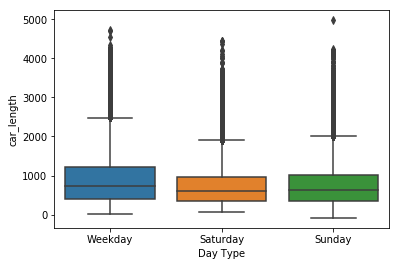

In [16]:
sns.boxplot(data=data, x='Day Type', y='car_length', 
               )

### Make a better plot 
Look at car_space over time

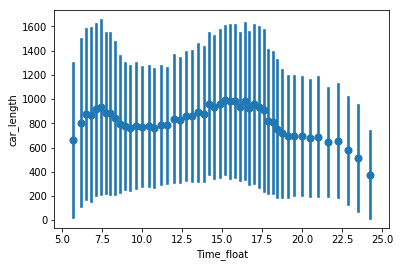

In [23]:
sns.regplot(x='Time_float', y='car_length',
            # hue='GTFS direction_id',
           data=data, 
           x_bins=50, 
           x_ci='sd',
           fit_reg=False)

### This graph is still not great
It's aggregating all buses and all directions together. Some buses don't do much rush-hour stuff

**Let's break it down by bus route**

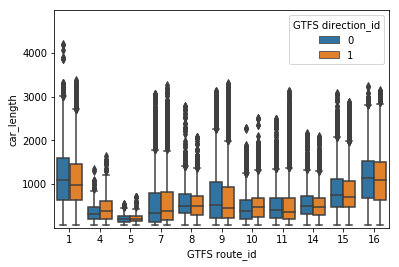

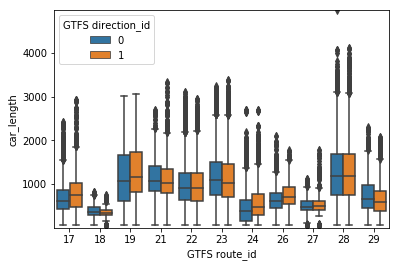

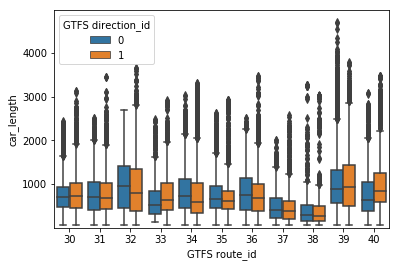

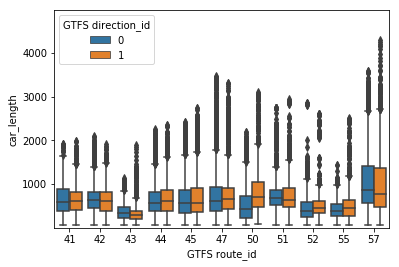

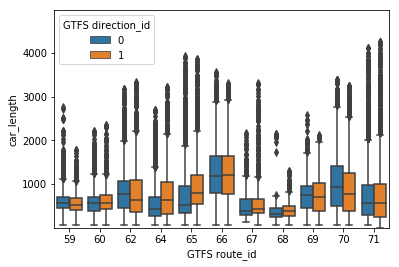

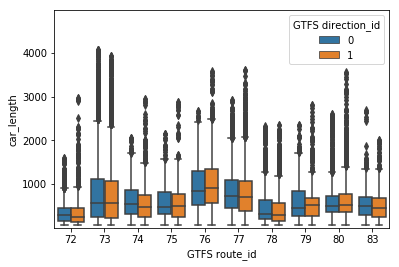

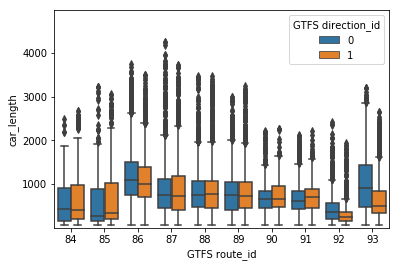

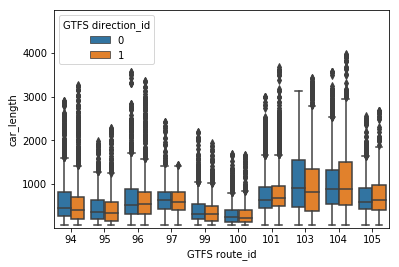

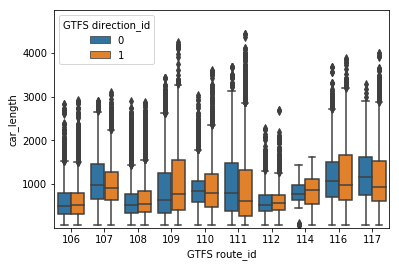

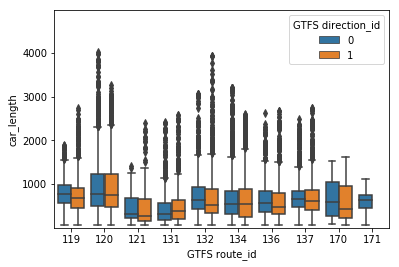

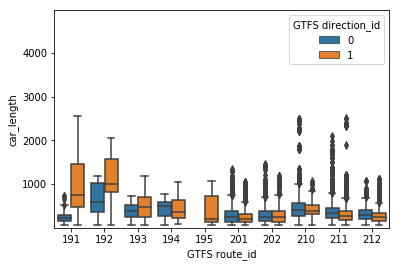

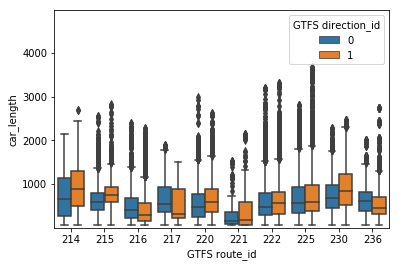

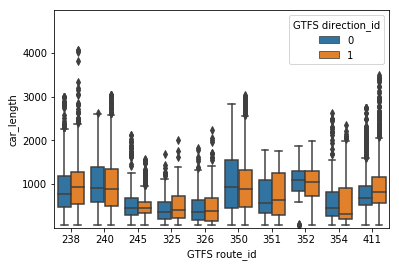

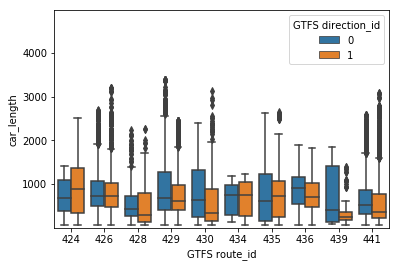

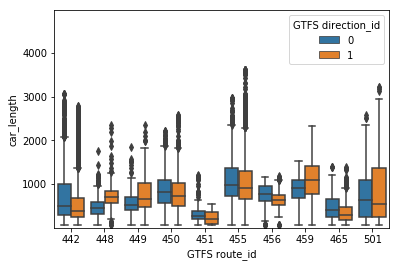

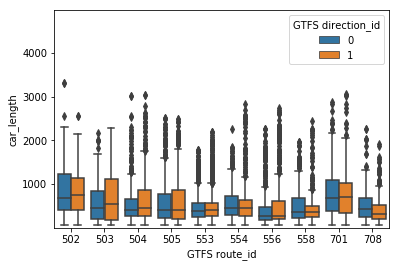

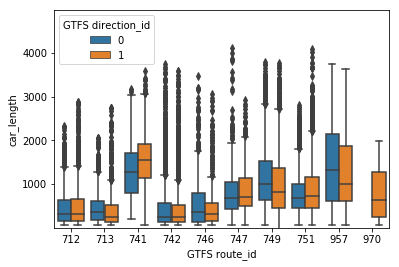

In [24]:
# 175 things is too many for one figure
def boxplot_all_routes(data):
    unique_routes = data['GTFS route_id'].unique()
    # 10 per grouping
    for routes in np.array_split(unique_routes, 
                                 np.floor(len(unique_routes)/10)):
        # subset and concatenate, then plot
        subset = pd.concat([data[data['GTFS route_id'] == route] for route in routes],
              axis=0)
        ax = sns.boxplot(x='GTFS route_id', y='car_length', 
                       hue='GTFS direction_id', 
                    #split=True, 
                      data=subset)
        ax.set_ylim(0, data['car_length'].max())
        ax.set_yticks([1000, 2000, 3000, 4000])
        plt.show()

boxplot_all_routes(data)

### Wow, that's a lot of routes
Let's find the largest passenger-load for each bus route (and direction) instead.

In [17]:
grouped = data.groupby(by=['GTFS route_id', 'Trip Start Time', 
                           'GTFS direction_id', 'Day Type'], 
                      )

In [18]:
# Sum up all the boardings that occur each trip
df_summed = grouped['Boardings', 'Alightings'].sum()
df_summed.head()

Boardings  \
GTFS route_id Trip Start Time GTFS direction_id Day Type              
1             04:37           0                 Weekday        15.9   
              04:40           0                 Saturday        8.9   
              04:57           0                 Weekday        19.9   
              05:00           0                 Saturday        9.0   
              05:10           1                 Saturday        9.1   

                                                          Alightings  
GTFS route_id Trip Start Time GTFS direction_id Day Type              
1             04:37           0                 Weekday         16.6  
              04:40           0                 Saturday         8.9  
              04:57           0                 Weekday         20.6  
              05:00           0                 Saturday         9.0  
              05:10           1                 Saturday         9.0

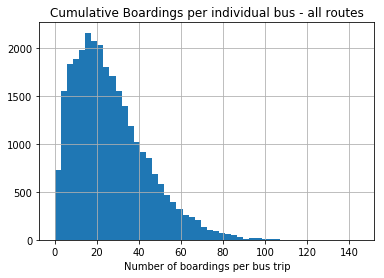

In [64]:
df_summed['Boardings'].hist(bins=50, cumulative=False)
plt.title('Cumulative Boardings per individual bus - all routes')
plt.xlabel('Number of boardings per bus trip')
plt.show()

In [20]:
# add in float_time column to all these things
idx = df_summed.index
times = idx.get_level_values(level=1)
float_times = times.to_series().apply(lambda x:
                             convert_time_to_linear(x))
float_times.name = 'float_time'
float_times.index = idx
df_summed_times = pd.concat([df_summed, float_times], axis=1).reset_index()

In [21]:
df_summed_times.head()

,GTFS route_id,Trip Start Time,GTFS direction_id,Day Type,Boardings,Alightings,float_time
0,1,04:37,0,Weekday,15.9,16.6,4.616667
1,1,04:40,0,Saturday,8.9,8.9,4.666667
2,1,04:57,0,Weekday,19.9,20.6,4.950000
3,1,05:00,0,Saturday,9.0,9.0,5.000000
4,1,05:10,1,Saturday,9.1,9.0,5.166667


In [68]:
# add a datetime index in case want to do some rolling-window
# stuff
datetime = pd.to_datetime(df_summed_times['float_time'], unit='h',
                        #origin=pd.to_datetime('1/1/2017')
                          origin='2017'
                         )
datetime.name = 'datetime'
df_datetime = pd.concat(
    [df_summed_times, datetime]
    , axis=1)
df_datetime = df_datetime.set_index('datetime')

# Drop everyting except boarding info
df_just_boardings = df_datetime.drop(['Trip Start Time', 
                                      'Alightings', 'float_time' 
                                     ], axis=1)
df_just_boardings

,GTFS route_id,GTFS direction_id,Day Type,Boardings
datetime,,,,
2017-01-01 04:37:00.000001200,1,0,Weekday,15.9
2017-01-01 04:40:00.000001200,1,0,Saturday,8.9
2017-01-01 04:57:00.000000000,1,0,Weekday,19.9
2017-01-01 05:00:00.000000000,1,0,Saturday,9.0
2017-01-01 05:10:00.000001200,1,1,Saturday,9.1
2017-01-01 05:10:00.000001200,1,1,Weekday,17.3
2017-01-01 05:16:59.999998800,1,0,Weekday,30.8
2017-01-01 05:19:59.999998800,1,0,Saturday,15.2
2017-01-01 05:30:00.000000000,1,1,Saturday,10.2


In [69]:
# datetime can be used to do some rolling-window calculations
# but they're not the most easy to explain to lay-audiences. Dropping
# that

# Get index of max boardings for all trips in given route/direction
# regardless of day type
max_idx = (df_just_boardings.reset_index()
           .groupby(['GTFS route_id', 'GTFS direction_id'])
           .idxmax()['Boardings']
           .values
          )
# get the datetimes along with the max boardings
df_max_boardings = df_just_boardings.iloc[max_idx]

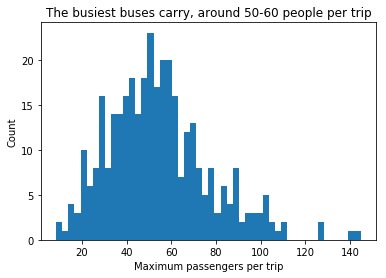

In [32]:
df_max_boardings.Boardings.hist(grid=False, bins=50)
plt.title('The busiest buses carry, around 50-60 people per trip')
plt.xlabel('Maximum passengers per trip')
plt.ylabel('Count')
plt.show()

In [33]:
# Convert boardings into car lengths
max_car_space = df_max_boardings['Boardings'].apply(lambda x: 
                                       car_space(x))
max_car_space.name = 'car_space'
df_final = pd.concat([df_max_boardings, max_car_space], axis=1)
df_final

,GTFS route_id,GTFS direction_id,Day Type,Boardings,car_space
datetime,,,,,
2017-01-01 16:33:00.000000000,1,0,Saturday,100.0,6301.884058
2017-01-01 07:54:00.000000000,1,1,Weekday,89.2,5628.840580
2017-01-01 17:06:00.000000000,4,0,Weekday,24.4,1590.579710
2017-01-01 07:37:59.999998800,4,1,Weekday,25.5,1659.130435
2017-01-01 10:30:00.000000000,5,0,Weekday,10.8,743.043478
2017-01-01 15:04:59.999998800,5,1,Weekday,13.4,905.072464
2017-01-01 17:12:00.000000000,7,0,Weekday,54.3,3453.913043
2017-01-01 08:19:59.999998800,7,1,Weekday,65.3,4139.420290
2017-01-01 14:30:00.000000000,8,0,Weekday,88.9,5610.144928


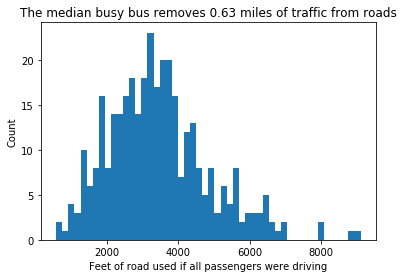

In [55]:
# same shape, different units
df_final.car_space.hist(grid=False, bins=50)
plt.title(('The median busy bus removes %.2f miles'
           ' of traffic from roads') 
          % (df_final['car_space'].median() / 5280))
plt.xlabel('Feet of road used if all passengers were driving')
plt.ylabel('Count')
plt.show()

## Final Thought

Each bus route deserves at least as much dedicated space as the cars that passengers would take at the busiest time of the route, if the route did not exist. 

I didn't have the data to guesstimate the number of people on the road at a given time-window, and it's a much more confusing proposition to explain. Reminder to self: being wonky is not a goal in and of itself.

This is obviously naive from an expert standpoint - people's mode of transit is flexible, and the conversion of bus-riders into car drivers wouldn't be 1:1.38 - not everyone can afford a car. But from a values-standpoint, it is simple and motivating. Road space is a democratic good, but is not equitably distributed. Here is a more equitable way to do so 

### Let's also look at the median bus for each route
Less good - b/c rush hour is really where buses are most useful and where they provide the most benefity

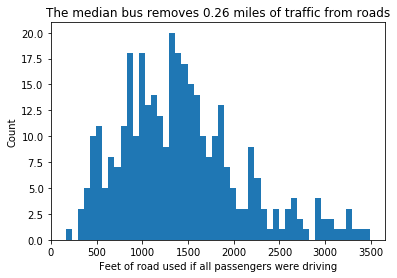

In [61]:
# Median load
df_median_boardings = (df_just_boardings.reset_index()
                       .groupby(['GTFS route_id',
                                 'GTFS direction_id'])
                       .median()
                      )

med_car_space = df_median_boardings['Boardings'].apply(lambda x: 
                                       car_space(x))
med_car_space.name = 'car_space'
df_final_median = pd.concat([df_median_boardings, med_car_space], axis=1)
df_final_median.car_space.hist(grid=False, bins=50)
plt.title(('The median bus removes %.2f miles'
           ' of traffic from roads') 
          % (df_final_median['car_space'].median() / 5280))
plt.xlabel('Feet of road used if all passengers were driving')
plt.ylabel('Count')
plt.show()

# Below are old graphs
They aren't that great. Decide how to finish them.

Routes!
 [1 4 5 7]


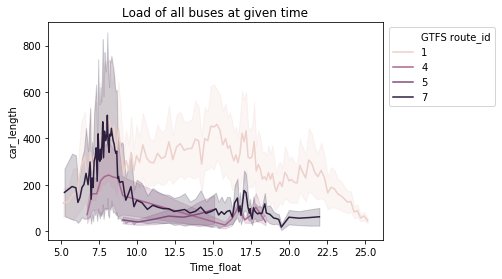

Routes!
 [ 8  9 10]


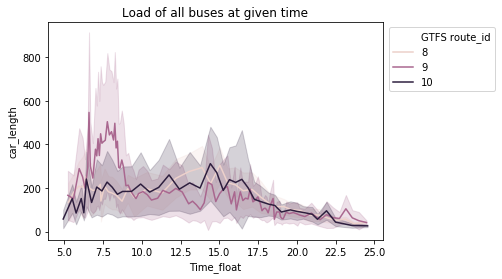

Routes!
 [11 14 15]


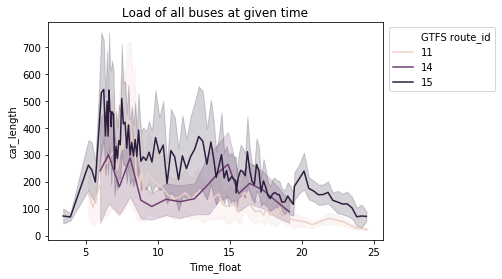

Routes!
 [16 17 18]


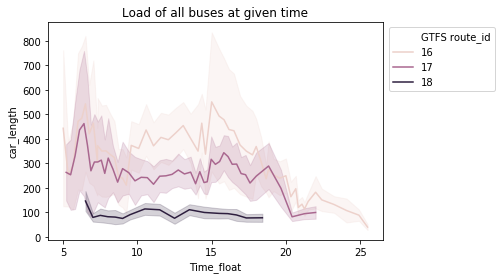

Routes!
 [19 21 22]


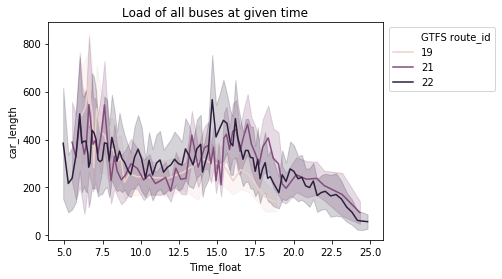

Routes!
 [23 24 26]


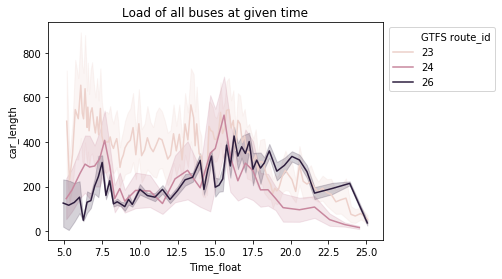

Routes!
 [27 28 29]


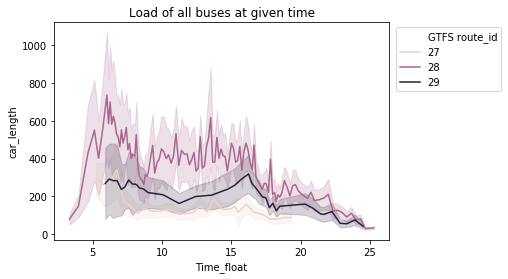

Routes!
 [30 31 32]


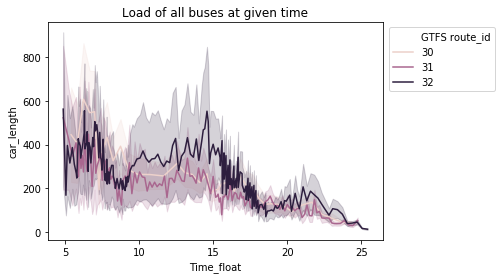

Routes!
 [33 34 35]


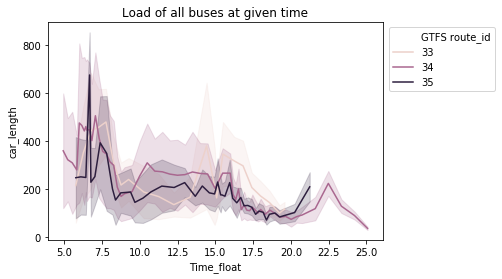

Routes!
 [36 37 38]


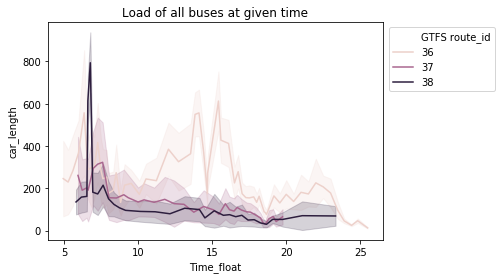

Routes!
 [39 40 41]


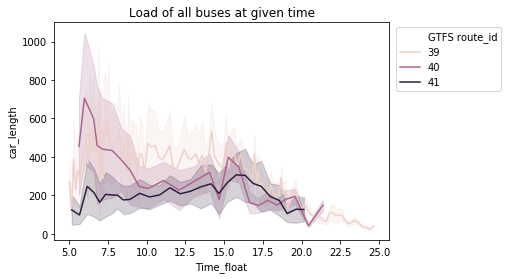

Routes!
 [42 43 44]


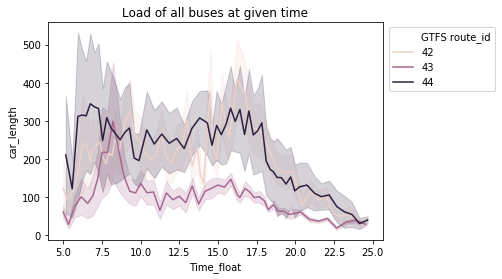

Routes!
 [45 47 50]


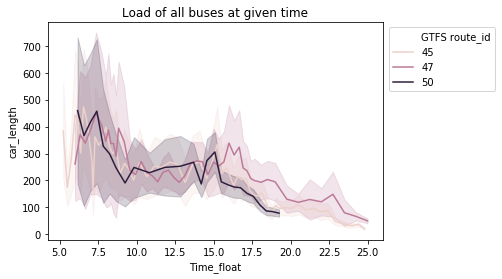

Routes!
 [51 52 55]


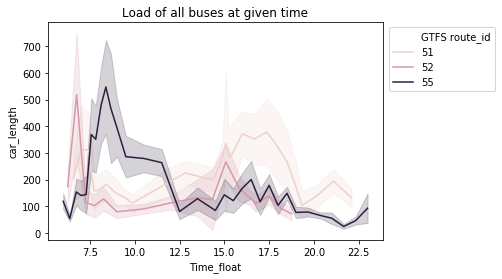

Routes!
 [57 59 60]


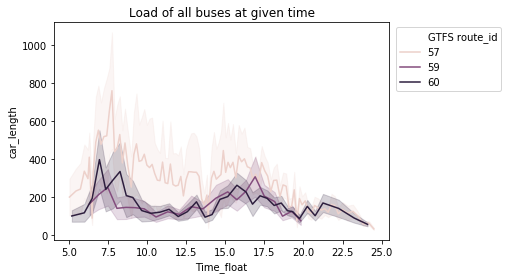

Routes!
 [62 64 65]


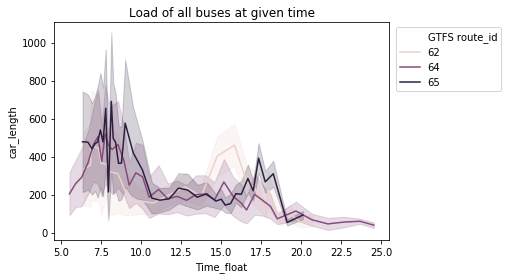

Routes!
 [66 67 68]


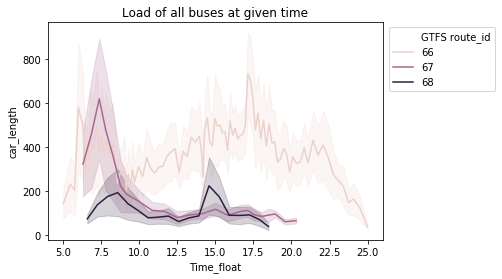

Routes!
 [69 70 71]


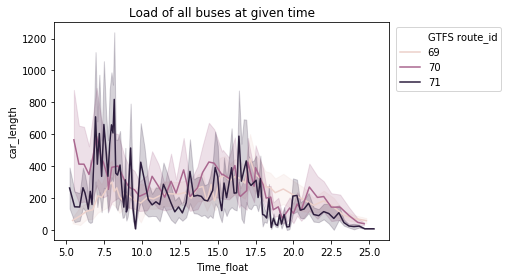

Routes!
 [72 73 74]


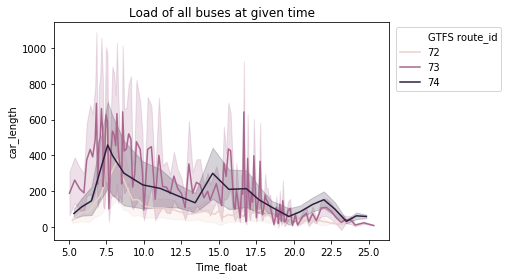

Routes!
 [75 76 77]


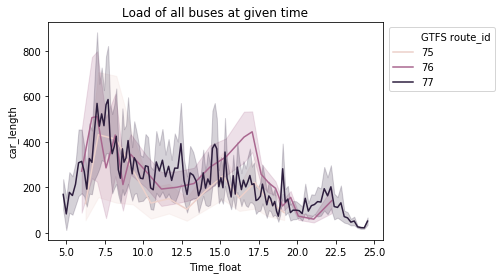

Routes!
 [78 79 80]


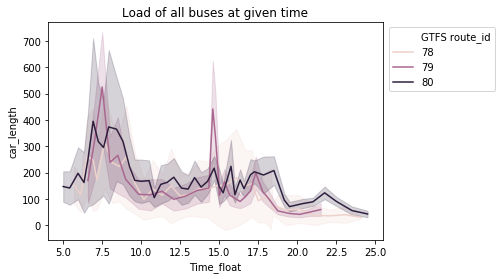

Routes!
 [83 84 85]


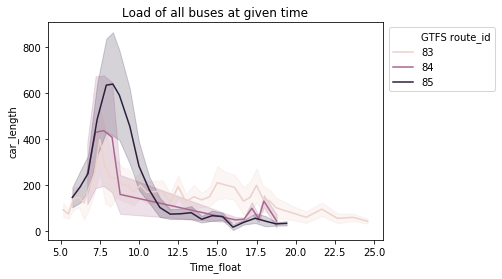

Routes!
 [86 87 88]


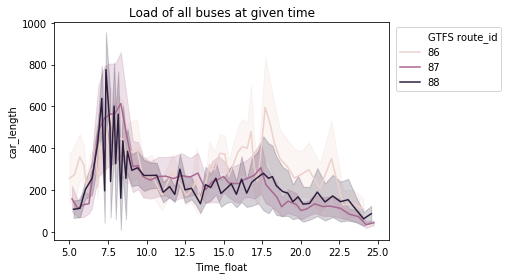

Routes!
 [89 90 91]


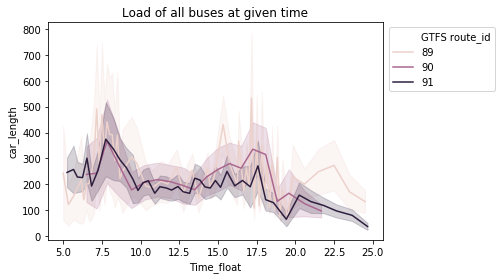

Routes!
 [92 93 94]


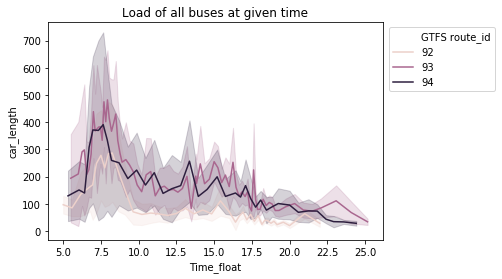

Routes!
 [95 96 97]


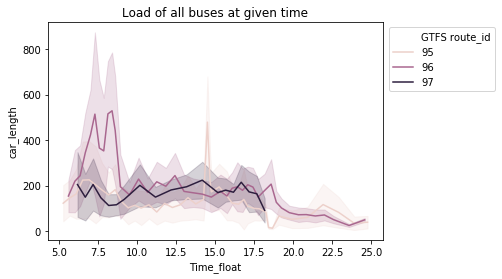

Routes!
 [ 99 100 101]


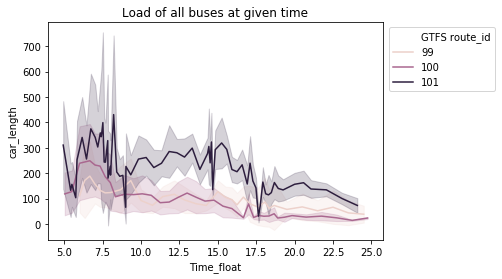

Routes!
 [103 104 105]


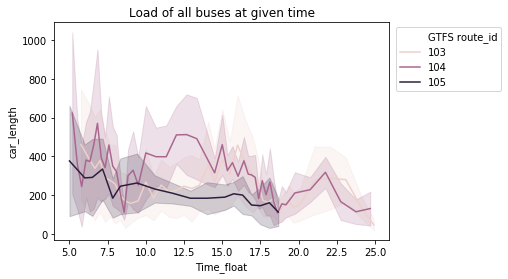

Routes!
 [106 107 108]


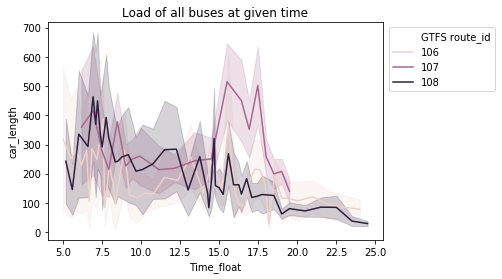

Routes!
 [109 110 111]


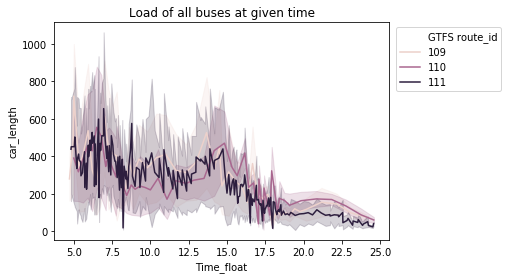

Routes!
 [112 114 116]


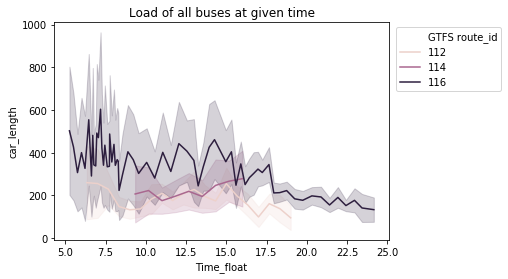

Routes!
 [117 119 120]


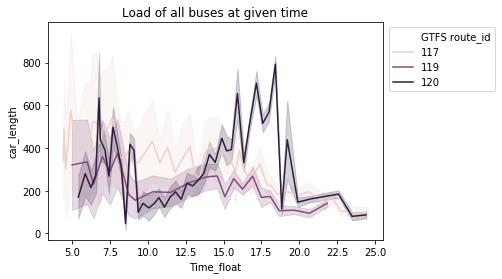

Routes!
 [121 131 132]


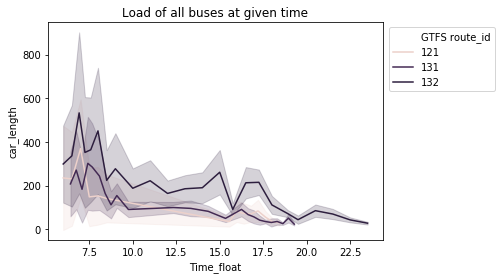

Routes!
 [134 136 137]


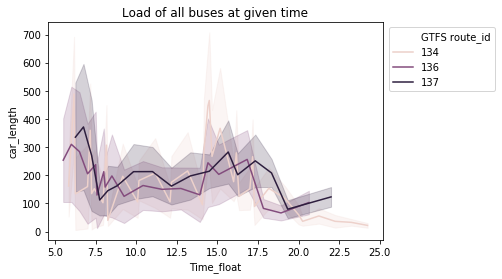

Routes!
 [170 171 191]


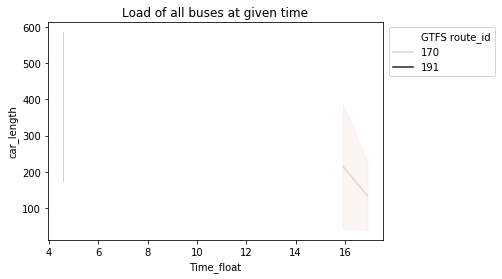

Routes!
 [192 193 194]


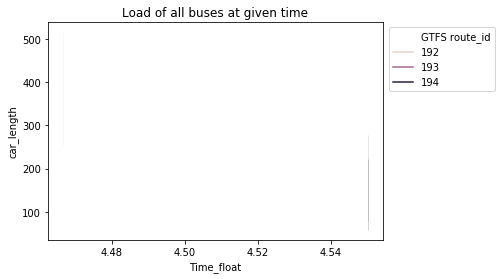

Routes!
 [195 201 202]


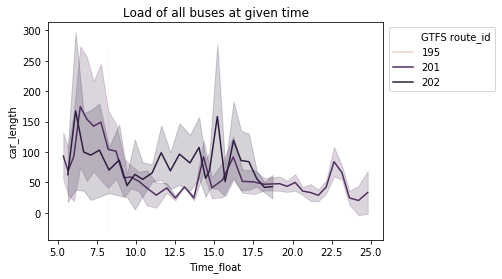

Routes!
 [210 211 212]


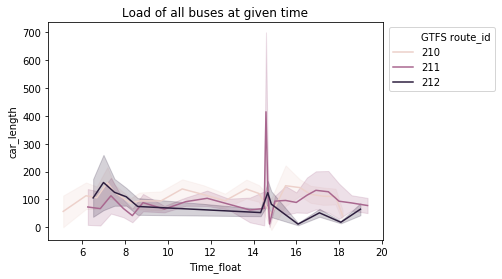

Routes!
 [214 215 216]


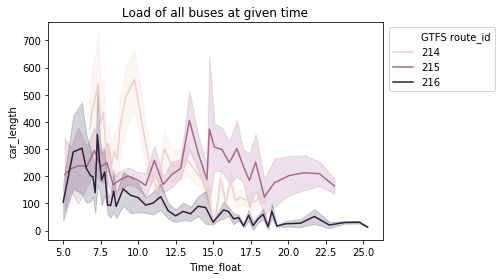

Routes!
 [217 220 221]


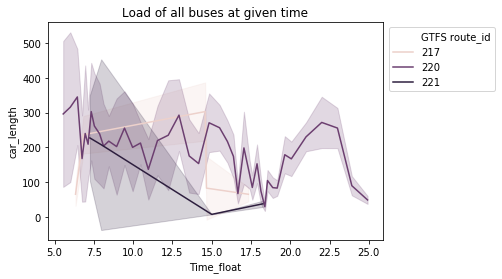

Routes!
 [222 225 230]


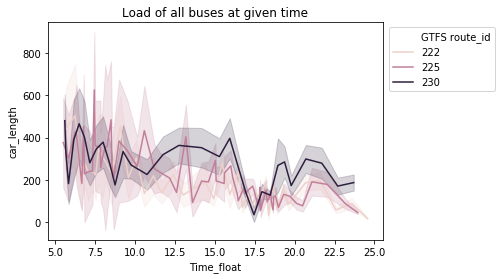

Routes!
 [236 238 240]


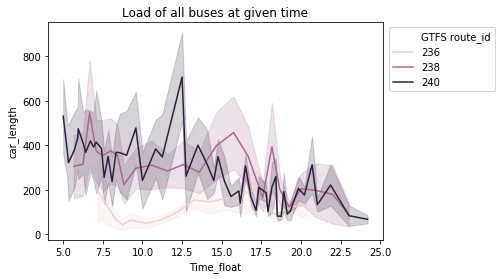

Routes!
 [245 325 326]


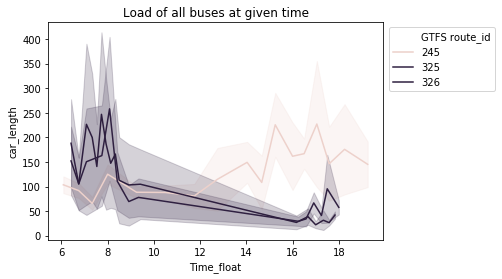

Routes!
 [350 351 352]


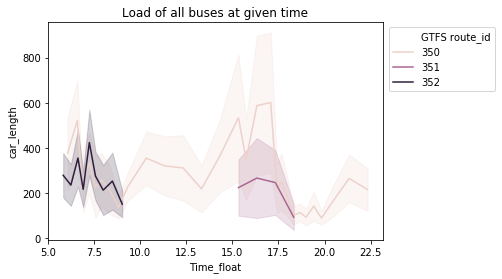

Routes!
 [354 411 424]


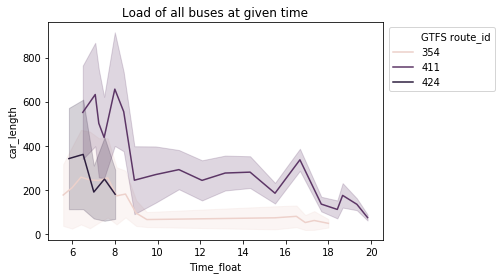

Routes!
 [426 428 429]


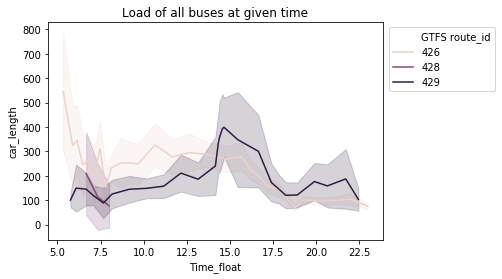

Routes!
 [430 434 435]


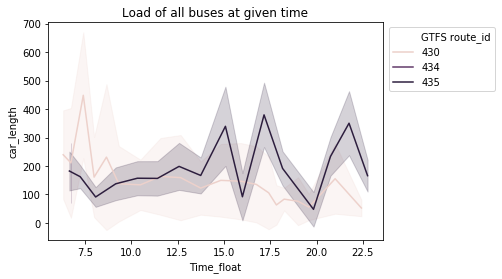

Routes!
 [436 439 441]


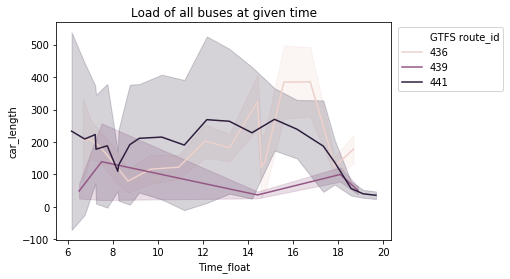

Routes!
 [442 448 449]


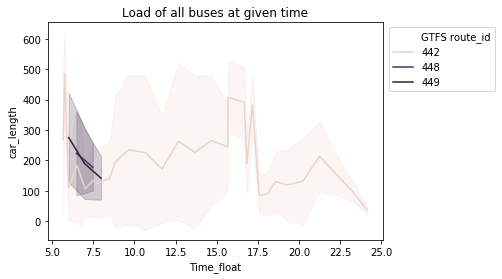

Routes!
 [450 451 455]


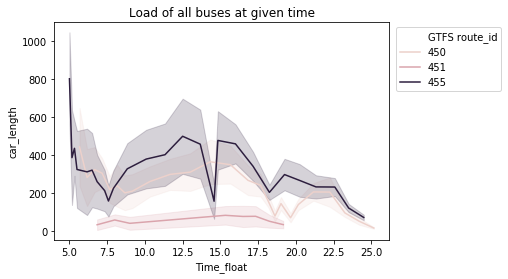

Routes!
 [456 459 465]


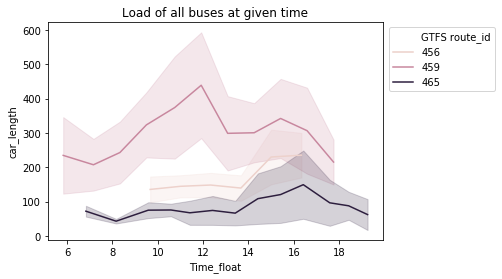

Routes!
 [501 502 503]


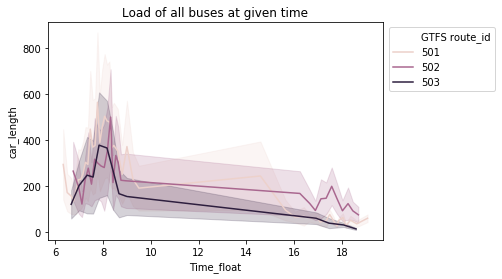

Routes!
 [504 505 553]


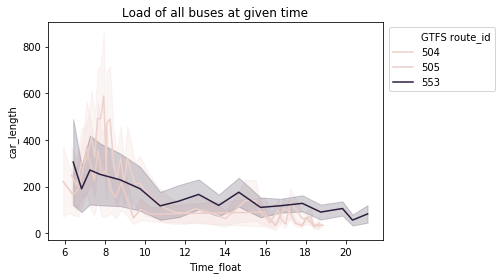

Routes!
 [554 556 558]


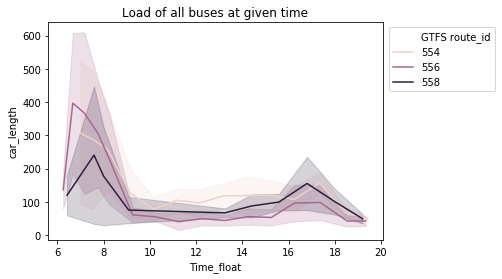

Routes!
 [701 708 712]


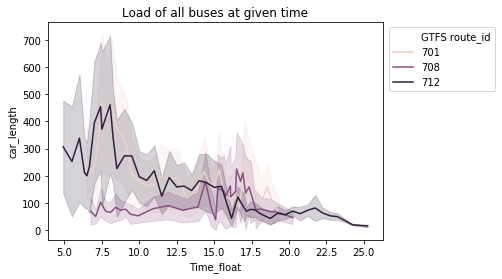

Routes!
 [713 741 742]


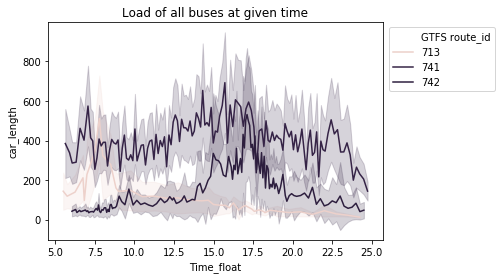

Routes!
 [746 747 749]


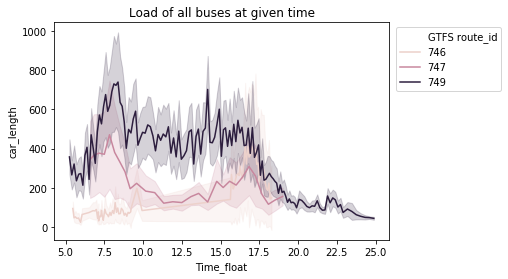

Routes!
 [751 957 970]


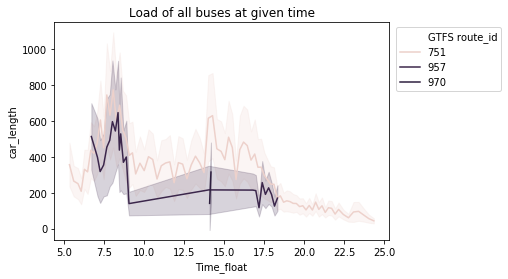

In [126]:
# plot some timeseries things
# 175 things is too many for one figure
unique_routes = data['GTFS route_id'].unique()

# 10 per grouping
for routes in np.array_split(unique_routes, 
                             len(unique_routes)/3):
    subset = pd.concat(
        [data[data['GTFS route_id'] == route]
            for route in routes])
    print('Routes!\n', subset['GTFS route_id'].unique())
    weekday = subset[((subset['Day Type'] == 'Weekday') &
                    (subset['GTFS direction_id'] == 1))]
    ax = sns.lineplot(x='Time_float', y='car_length', 
                 hue='GTFS route_id',
                data=weekday, ci='sd',
                 legend='full'
                )
    ax.legend(bbox_to_anchor=(1.35, 1.0))
    plt.title('Load of all buses at given time')
    plt.show()